# YouTube Trending Videos Statistical Analysis

## INTRODUCTION

#### to be edited</b>
<b>https://www.kaggle.com/rsrishav/youtube-trending-video-dataset

In [84]:
# Importing libraries
import functools
from functools import reduce
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
import seaborn as sns

import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
'''
Later on we can also remove the ones we wouldn't use
'''
# Importing dataset
data_gb = pd.read_csv("../data/GB_youtube_trending_data.csv",sep=",")  #uk  
data_fr = pd.read_csv("../data/FR_youtube_trending_data.csv",sep=",")  #france
data_us = pd.read_csv("../data/US_youtube_trending_data.csv",sep=",")  #usa 
data_ru = pd.read_csv("../data/RU_youtube_trending_data.csv",sep=",")  #russia
data_de = pd.read_csv("../data/DE_youtube_trending_data.csv",sep=",")  #germany 
data_ca = pd.read_csv("../data/CA_youtube_trending_data.csv",sep=",")  #canada   
data_kr = pd.read_csv("../data/KR_youtube_trending_data.csv",sep=",")  #southkorea   
data_jp = pd.read_csv("../data/JP_youtube_trending_data.csv",sep=",")  #japan
data_br = pd.read_csv("../data/BR_youtube_trending_data.csv",sep=",")  #brazil
data_mx = pd.read_csv("../data/MX_youtube_trending_data.csv",sep=",")  #mexico

## Data Cleaning & Wrangling

In [3]:
'''
Adding json files
'''
gb_json = pd.read_json('../data/GB_category_id.json')
fr_json = pd.read_json('../data/FR_category_id.json')
us_json = pd.read_json('../data/US_category_id.json')
ru_json = pd.read_json('../data/RU_category_id.json')
de_json = pd.read_json('../data/DE_category_id.json')
ca_json = pd.read_json('../data/CA_category_id.json')
kr_json = pd.read_json('../data/KR_category_id.json')
jp_json = pd.read_json('../data/JP_category_id.json')
br_json = pd.read_json('../data/BR_category_id.json')
mx_json = pd.read_json('../data/MX_category_id.json')

In [4]:
'''
Defining function to flat json files to get rid of dictionary format for every country
'''

col_list = ["items","items_snippet"]

def flat_func(df,column):
    for column in col_list:
        flatten = pd.DataFrame(dict(df[column])).transpose()
        columns = [str(i) for i in flatten.columns]
        flatten.columns = [column + "_" + str(colname) for colname in columns]
        df = pd.concat([df,flatten],axis=1)
        df = df.drop(column,axis=1)
    return df

In [5]:
'''
Applying function
Creating flat databases
'''

gb_flat = flat_func(gb_json,col_list)[["items_id","items_snippet_title"]]
fr_flat = flat_func(fr_json,col_list)[["items_id","items_snippet_title"]]
us_flat = flat_func(us_json,col_list)[["items_id","items_snippet_title"]]
ru_flat = flat_func(ru_json,col_list)[["items_id","items_snippet_title"]]
de_flat = flat_func(de_json,col_list)[["items_id","items_snippet_title"]]
ca_flat = flat_func(ca_json,col_list)[["items_id","items_snippet_title"]]
kr_flat = flat_func(kr_json,col_list)[["items_id","items_snippet_title"]]
jp_flat = flat_func(jp_json,col_list)[["items_id","items_snippet_title"]]
br_flat = flat_func(br_json,col_list)[["items_id","items_snippet_title"]]
mx_flat = flat_func(mx_json,col_list)[["items_id","items_snippet_title"]]

In [6]:
'''
Dropping categoryId 29 for each country
'''

data_countries = [data_gb,data_fr,data_us,data_ru,data_de,data_ca,data_kr,data_jp,data_br,data_mx]

def category_remover(country):
    drop_idx = country[country["categoryId"]==29].index
    return drop_idx

data_gb = data_gb.drop(category_remover(data_gb))
data_fr = data_fr.drop(category_remover(data_fr))
data_us = data_us.drop(category_remover(data_us))
data_ru = data_ru.drop(category_remover(data_ru))
data_de = data_de.drop(category_remover(data_de))
data_ca = data_ca.drop(category_remover(data_ca))
data_kr = data_kr.drop(category_remover(data_kr))
data_jp = data_jp.drop(category_remover(data_jp))
data_br = data_br.drop(category_remover(data_br))
data_mx = data_mx.drop(category_remover(data_mx))

In [7]:
'''
Creating function to add trend name next to categoryId for every country
'''
def trend_adder(country_df,country_flat):
    trend = []
    for trend_id in country_df["categoryId"]:
        for i in range(0,len(country_flat)):
            if trend_id == int(country_flat["items_id"][i]):
                trend.append(country_flat["items_snippet_title"][i])

    country_df.insert(6,"trend",trend)     

In [8]:
'''
Applying Function
Adding trend column next to categoryId for every country
'''
trend_order_data_country = [data_gb,data_fr,data_us,data_ru,data_de,
                            data_ca,data_kr,data_jp,data_br,data_mx]

trend_order_data_flat = [gb_flat,fr_flat,us_flat,ru_flat,de_flat,
                         ca_flat,kr_flat,jp_flat,br_flat,mx_flat]

for i in range(0,len(trend_order_data_country)):
    trend_adder(trend_order_data_country[i],trend_order_data_flat[i])

In [9]:
'''
Scrapping the most updated row for each link.

'''

def get_recent_idx(country):
    latest_idx = []
    for link in np.array(country["video_id"].unique()):
        latest_row = country[(country["video_id"] ==
                                      link)][["view_count"]].nlargest(1,"view_count").index[0]
    
        latest_idx.append(latest_row)
    return country[country.index.isin(latest_idx)]
   
data_gb_unique = get_recent_idx(data_gb)
data_fr_unique = get_recent_idx(data_fr)
data_us_unique = get_recent_idx(data_us)
data_ru_unique = get_recent_idx(data_ru)
data_de_unique = get_recent_idx(data_de)
data_ca_unique = get_recent_idx(data_ca)
data_kr_unique = get_recent_idx(data_kr)
data_jp_unique = get_recent_idx(data_jp)
data_br_unique = get_recent_idx(data_br)
data_mx_unique = get_recent_idx(data_mx)

## Data Visualization

Text(0.5, 1.0, 'Correlation Heatmap of UK')

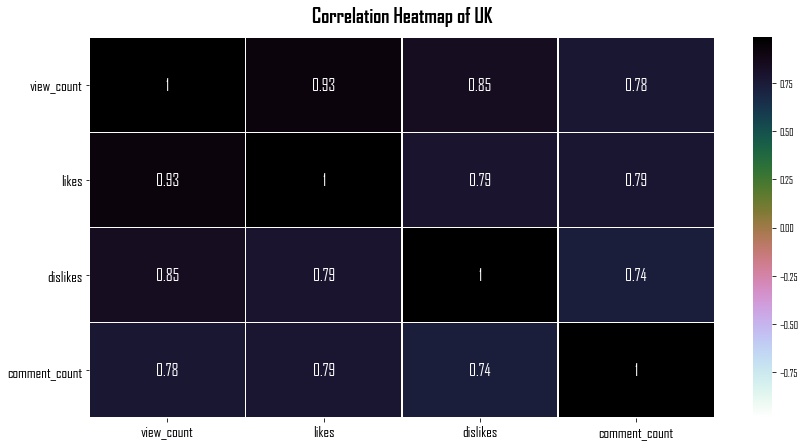

In [10]:
'''
Creating correlation heatmap.
'''

# Setting plot parameters
plt.rcParams["font.family"] = "agency fb"
plt.rcParams["figure.figsize"] = (14,7)


data_gb_numerical = data_gb_unique[["view_count","likes","dislikes","comment_count"]]

sns.heatmap(data_gb_numerical.corr(),annot=True,annot_kws={"size": 16},
            vmin=-0.99,vmax=0.99,cbar=True,linewidth=0.5, cmap="cubehelix_r")
plt.xticks(size=15)
plt.yticks(rotation=0,size=15)
plt.title("Correlation Heatmap of UK",size=20,fontweight="bold",pad=15)

In [11]:
'''
Creating Pivot Table Function for country comparison (pivot_table_country_comparison)
- Will be used to compare country attributes
'''

def pivot_table_country_comparison(df):
    return lambda data: pd.pivot_table(df,values=("comment_count","view_count","likes","dislikes"
                                                 ),index="trend").sort_values(by="likes",ascending
                                                                              ="False")
# Applying function

pt_gb = pivot_table_country_comparison(data_gb_unique)
pt_fr = pivot_table_country_comparison(data_fr_unique)
pt_us = pivot_table_country_comparison(data_us_unique)
pt_ru = pivot_table_country_comparison(data_ru_unique)
pt_de = pivot_table_country_comparison(data_de_unique)
pt_ca = pivot_table_country_comparison(data_ca_unique)
pt_kr = pivot_table_country_comparison(data_kr_unique)
pt_jp = pivot_table_country_comparison(data_jp_unique)
pt_br = pivot_table_country_comparison(data_br_unique)
pt_mx = pivot_table_country_comparison(data_mx_unique)

# Calling lambda function

pv_table = pivot_table_country_comparison(data_gb_unique)

# Applying lambda function

pt_gb = pt_gb(pv_table)
pt_fr = pt_fr(pv_table)
pt_us = pt_us(pv_table)
pt_ru = pt_ru(pv_table)
pt_de = pt_de(pv_table)
pt_ca = pt_ca(pv_table)
pt_kr = pt_kr(pv_table)
pt_jp = pt_jp(pv_table)
pt_br = pt_br(pv_table)
pt_mx = pt_mx(pv_table)

# Renaming columns & adding suffix (view_count_UK,likes_UK,dislikes_Mexico etc..)

plot_titles_countries = ["UK","France","USA","Russia","Germany","Canada",
                         "SouthKorea","Japan","Brazil","Mexico"]


pt_gb.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[0]),
                      "view_count":("view_count" + "_" + plot_titles_countries[0]),
                     "likes":("likes" + "_" + plot_titles_countries[0]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[0])},
             inplace=True)

pt_fr.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[1]),
                      "view_count":("view_count" + "_" + plot_titles_countries[1]),
                     "likes":("likes" + "_" + plot_titles_countries[1]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[1])},
             inplace=True)

pt_us.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[2]),
                      "view_count":("view_count" + "_" + plot_titles_countries[2]),
                     "likes":("likes" + "_" + plot_titles_countries[2]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[2])},
             inplace=True)

pt_ru.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[3]),
                      "view_count":("view_count" + "_" + plot_titles_countries[3]),
                     "likes":("likes" + "_" + plot_titles_countries[3]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[3])},
             inplace=True)

pt_de.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[4]),
                      "view_count":("view_count" + "_" + plot_titles_countries[4]),
                     "likes":("likes" + "_" + plot_titles_countries[4]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[4])},
             inplace=True)

pt_ca.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[5]),
                      "view_count":("view_count" + "_" + plot_titles_countries[5]),
                     "likes":("likes" + "_" + plot_titles_countries[5]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[5])},
             inplace=True)

pt_kr.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[6]),
                      "view_count":("view_count" + "_" + plot_titles_countries[6]),
                     "likes":("likes" + "_" + plot_titles_countries[6]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[6])},
             inplace=True)

pt_jp.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[7]),
                      "view_count":("view_count" + "_" + plot_titles_countries[7]),
                     "likes":("likes" + "_" + plot_titles_countries[7]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[7])},
             inplace=True)

pt_br.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[8]),
                      "view_count":("view_count" + "_" + plot_titles_countries[8]),
                     "likes":("likes" + "_" + plot_titles_countries[8]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[8])},
             inplace=True)

pt_mx.rename(columns={"comment_count":("comment_count" + "_" + plot_titles_countries[9]),
                      "view_count":("view_count" + "_" + plot_titles_countries[9]),
                     "likes":("likes" + "_" + plot_titles_countries[9]),
                     "dislikes":("dislikes" + "_" + plot_titles_countries[9])},
             inplace=True)

# Merging columns to create df_final



dfs = [pt_gb, pt_fr, pt_us,pt_ru,pt_de,pt_ca,pt_kr,pt_jp,pt_br,pt_mx]
df_final = reduce(lambda left,right: pd.merge(left,right,how="outer",
                                              left_index=True,right_index=True), dfs)

In [12]:
df_final.sample(4)

,comment_count_UK,dislikes_UK,likes_UK,view_count_UK,comment_count_France,dislikes_France,likes_France,view_count_France,comment_count_USA,dislikes_USA,...,likes_Japan,view_count_Japan,comment_count_Brazil,dislikes_Brazil,likes_Brazil,view_count_Brazil,comment_count_Mexico,dislikes_Mexico,likes_Mexico,view_count_Mexico
trend,,,,,,,,,,,,,,,,,,,,,
Education,6271.031250,967.078125,75841.265625,1.170114e+06,1226.985294,311.441176,22394.235294,3.162847e+05,6479.456140,1064.877193,...,10724.333333,7.722779e+05,862.723684,279.921053,10417.394737,1.376712e+05,2331.947368,381.631579,21359.157895,3.081597e+05
Entertainment,9759.206774,2467.647059,121840.914439,1.946203e+06,3998.693498,913.431889,65318.947368,7.461962e+05,13630.905830,3276.573991,...,29573.032012,9.096749e+05,6077.642249,1563.136286,103898.451448,1.054185e+06,9144.664516,2637.077419,129151.359140,1.677363e+06
Sports,2217.882883,668.968468,21429.313814,8.656778e+05,1253.515892,398.058680,15048.943765,5.374870e+05,3820.092179,1120.117318,...,5807.570312,4.896931e+05,1704.000000,687.993407,32783.692308,6.011174e+05,1969.209486,811.391304,27167.237154,1.036891e+06
Gaming,10952.930000,3659.450000,120940.440000,2.546376e+06,6516.933333,2852.550000,68887.775000,1.781376e+06,13162.171171,4080.067568,...,35305.603774,1.385355e+06,6285.895522,2299.706468,129779.104478,1.926421e+06,8373.968750,2942.406250,134846.491071,2.018433e+06


In [13]:
'''
Grouping df_final database and creating new databases in order to compare country attributes
Ex: Total likes for each country
Ex: Total dislikes for each country
'''

countries_like_columns = ["likes_UK","likes_France","likes_USA","likes_Russia","likes_Germany",
                          "likes_Canada","likes_SouthKorea","likes_Japan",
                          "likes_Brazil","likes_Mexico"]

countries_dislike_columns = ["dislikes_UK","dislikes_France","dislikes_USA","dislikes_Russia",
                          "dislikes_Germany","dislikes_Canada","dislikes_SouthKorea",
                          "dislikes_Japan","dislikes_Brazil","dislikes_Mexico"]

countries_comment_count_columns = ["comment_count_UK","comment_count_France","comment_count_USA",
                             "comment_count_Russia","comment_count_Germany","comment_count_Canada",
                             "comment_count_SouthKorea","comment_count_Japan",
                                   "comment_count_Brazil","comment_count_Mexico"]

countries_view_count_columns = ["view_count_UK","view_count_France","view_count_USA",
                             "view_count_Russia","view_count_Germany","view_count_Canada",
                             "view_count_SouthKorea","view_count_Japan","view_count_Brazil",
                                "view_count_Mexico"]


countries_like = pd.pivot_table(df_final,values=countries_like_columns,index="trend")
countries_dislike = pd.pivot_table(df_final,values=countries_dislike_columns,index="trend")
countries_comment_count = pd.pivot_table(df_final,values=countries_comment_count_columns,index="trend")
countries_view_count = pd.pivot_table(df_final,values=countries_view_count_columns,index="trend")

In [14]:
'''
-----------------------------------------LIKES------------------------------------------------

Ordering new created database "countries_like" in order to draw graph

'''
# Index ordering
#Summing up total likes in each trend for all countries in order to order graph
total_numbers = []
for i in range(14):
    total_trend = countries_like.iloc[i,:].sum()
    countries_like.index[i]
    total_numbers.append(total_trend)
    total_numbers = sorted(total_numbers,reverse=True)

trend_names = []
for i in range(14):
    for j in range(14):
        if countries_like.iloc[i,:].sum() == total_numbers[j]:
            trend_names.append(countries_like.index[j])
            
'''
Changing index order based on above calculation in the "countries_like" dataframe
Ex;
1-Music
2-Comedy 
3-Sports etc.
'''

countries_like_ordered = countries_like.reindex(index=trend_names)
countries_like_ordered.head(3)

# Column ordering
'''
Ordering columns(countries) based on total likes 
'''
total_numbers_cols = []
for i in countries_like:
    total_country_like = countries_like.loc[:,i].sum()
    total_numbers_cols.append(total_country_like)
    total_numbers_cols = sorted(total_numbers_cols,reverse=True)

col_names_ordered = []
for i in range(10):
    for j in countries_like.columns:
        if total_numbers_cols[i] == countries_like.loc[:,j].sum():
            col_names_ordered.append(j)

countries_like_ordered = countries_like_ordered[col_names_ordered]

In [15]:
'''
-----------------------------------------DISLIKES-----------------------------------------------

Ordering new created database "countries_dislike" in order to draw graph

'''

# Index ordering
total_numbers = []
for i in range(14):
    total_trend = countries_dislike.iloc[i,:].sum()
    countries_dislike.index[i]
    total_numbers.append(total_trend)
    total_numbers = sorted(total_numbers,reverse=True)

trend_names = []
for i in range(14):
    for j in range(14):
        if countries_dislike.iloc[i,:].sum() == total_numbers[j]:
            trend_names.append(countries_dislike.index[j])

'''
Changing index order based on above calculation in the "countries_dislike" dataframe
Ex;
1-Music
2-Comedy 
3-Sports etc.
'''

countries_dislike_ordered = countries_dislike.reindex(index=trend_names)
countries_dislike_ordered.head(3)


# Column ordering
'''
Ordering columns(countries) based on total likes 
'''
total_numbers_cols = []
for i in countries_dislike:
    total_country_like = countries_dislike.loc[:,i].sum()
    total_numbers_cols.append(total_country_like)
    total_numbers_cols = sorted(total_numbers_cols,reverse=True)

col_names_ordered = []
for i in range(10):
    for j in countries_dislike.columns:
        if total_numbers_cols[i] == countries_dislike.loc[:,j].sum():
            col_names_ordered.append(j)

countries_dislike_ordered = countries_dislike_ordered[col_names_ordered]

In [16]:
'''
-----------------------------------------VIEW_COUNTS------------------------------------------------

Ordering new created database "countries_view_count" in order to draw graph

'''
# Index ordering
#Summing up total view_count in each trend for all countries in order to order graph
total_numbers = []
for i in range(14):
    total_trend = countries_view_count.iloc[i,:].sum()
    countries_view_count.index[i]
    total_numbers.append(total_trend)
    total_numbers = sorted(total_numbers,reverse=True)

trend_names = []
for i in range(14):
    for j in range(14):
        if countries_view_count.iloc[i,:].sum() == total_numbers[j]:
            trend_names.append(countries_view_count.index[j])
            
'''
Changing index order based on above calculation in the "countries_view_count" dataframe
Ex;
1-Music
2-Comedy 
3-Sports etc.
'''


countries_view_count_ordered = countries_view_count.reindex(index=trend_names)
countries_view_count.head(3)

# Column ordering
'''
Ordering columns(countries) based on total likes 
'''
total_numbers_cols = []
for i in countries_view_count:
    total_country_like = countries_view_count.loc[:,i].sum()
    total_numbers_cols.append(total_country_like)
    total_numbers_cols = sorted(total_numbers_cols,reverse=True)

col_names_ordered = []
for i in range(10):
    for j in countries_view_count.columns:
        if total_numbers_cols[i] == countries_view_count.loc[:,j].sum():
            col_names_ordered.append(j)

countries_view_count_ordered = countries_view_count[col_names_ordered]

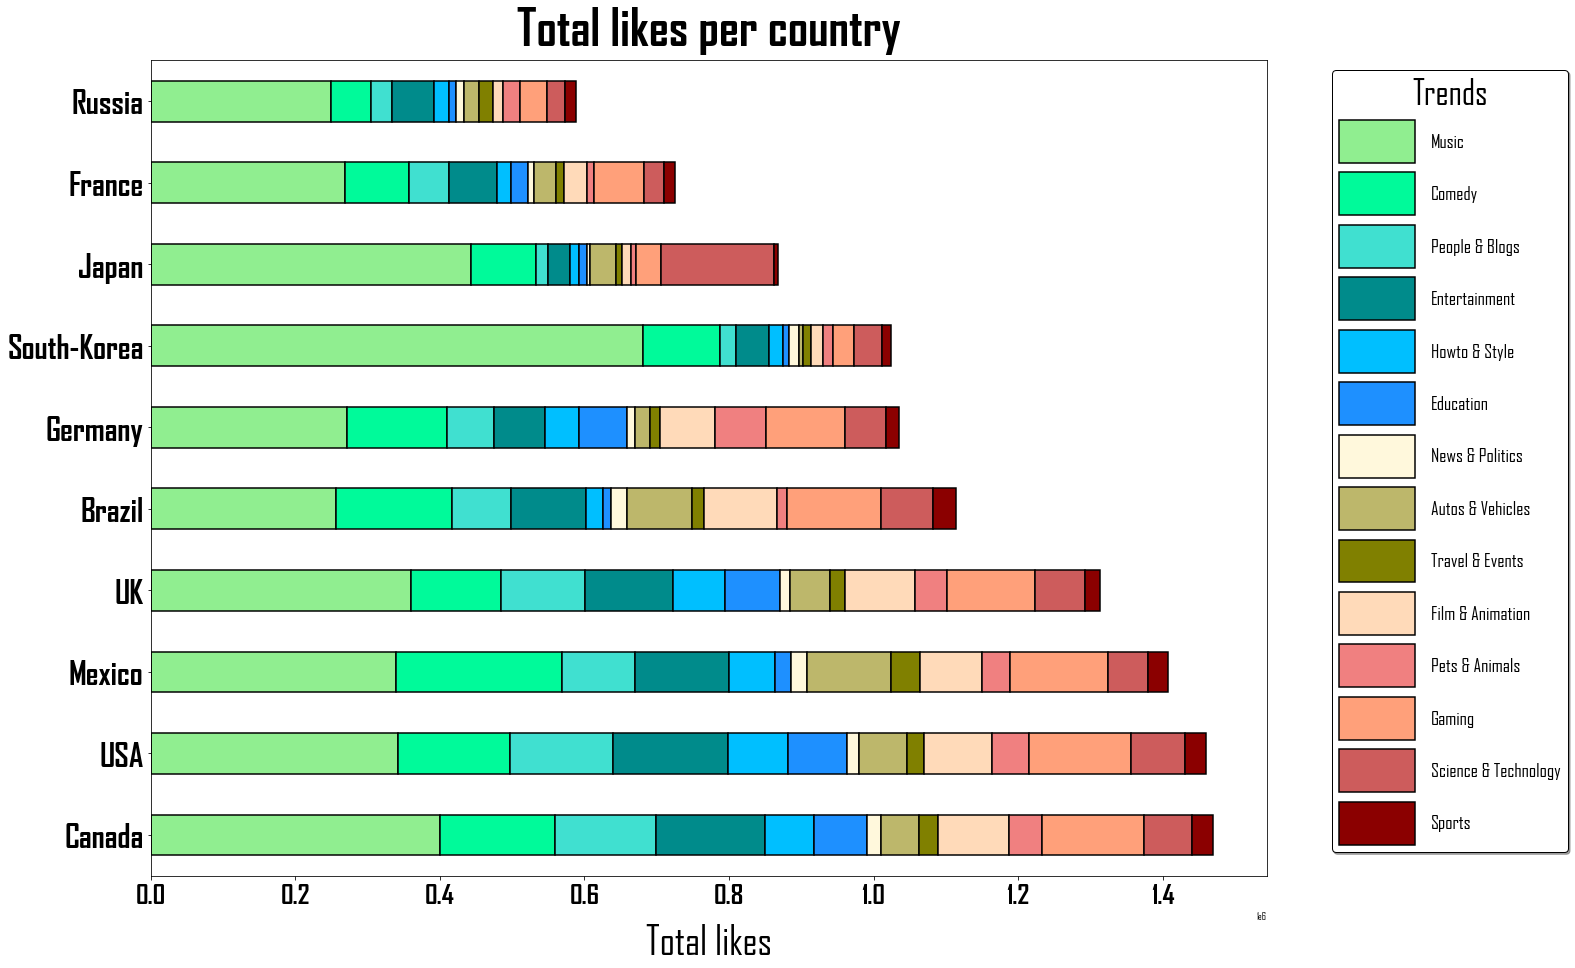

In [17]:
'''
------------------------------Comparing country results - LIKES ----------------------------------
'''
# Setting Parameters
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams['legend.handlelength'] = 4
plt.rcParams['legend.handleheight'] = 3.1
fontP = FontProperties()


# Manually setting colors
colors = ["lightgreen","mediumspringgreen","turquoise","darkcyan","deepskyblue",
          "dodgerblue","cornsilk","darkkhaki","olive","peachpuff","lightcoral",
          "lightsalmon","indianred","darkred"]

# This is the dataframe
countries_like_ordered.T.plot(kind="barh",stacked=True,color=colors,linewidth=1.5,edgecolor="k")

# Adjusting xticks and yticks
positions = (0,1,2,3,4,5,6,7,8,9)
labels_likes=["Russia","France","Japan","South-Korea","Germany","Brazil","UK",
                "Mexico","USA","Canada"]

plt.yticks(positions,labels=labels_likes[::-1],size=32,fontweight="bold")
plt.xticks(size=27,fontweight="bold")
plt.title("Total likes per country",size=50,fontweight="bold",pad=15)
plt.xlabel("Total likes",size=40,labelpad=15)
 
# Adding legend
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left',prop={"size":19},
           shadow=True,facecolor="white",edgecolor="k",title="Trends",title_fontsize=35)

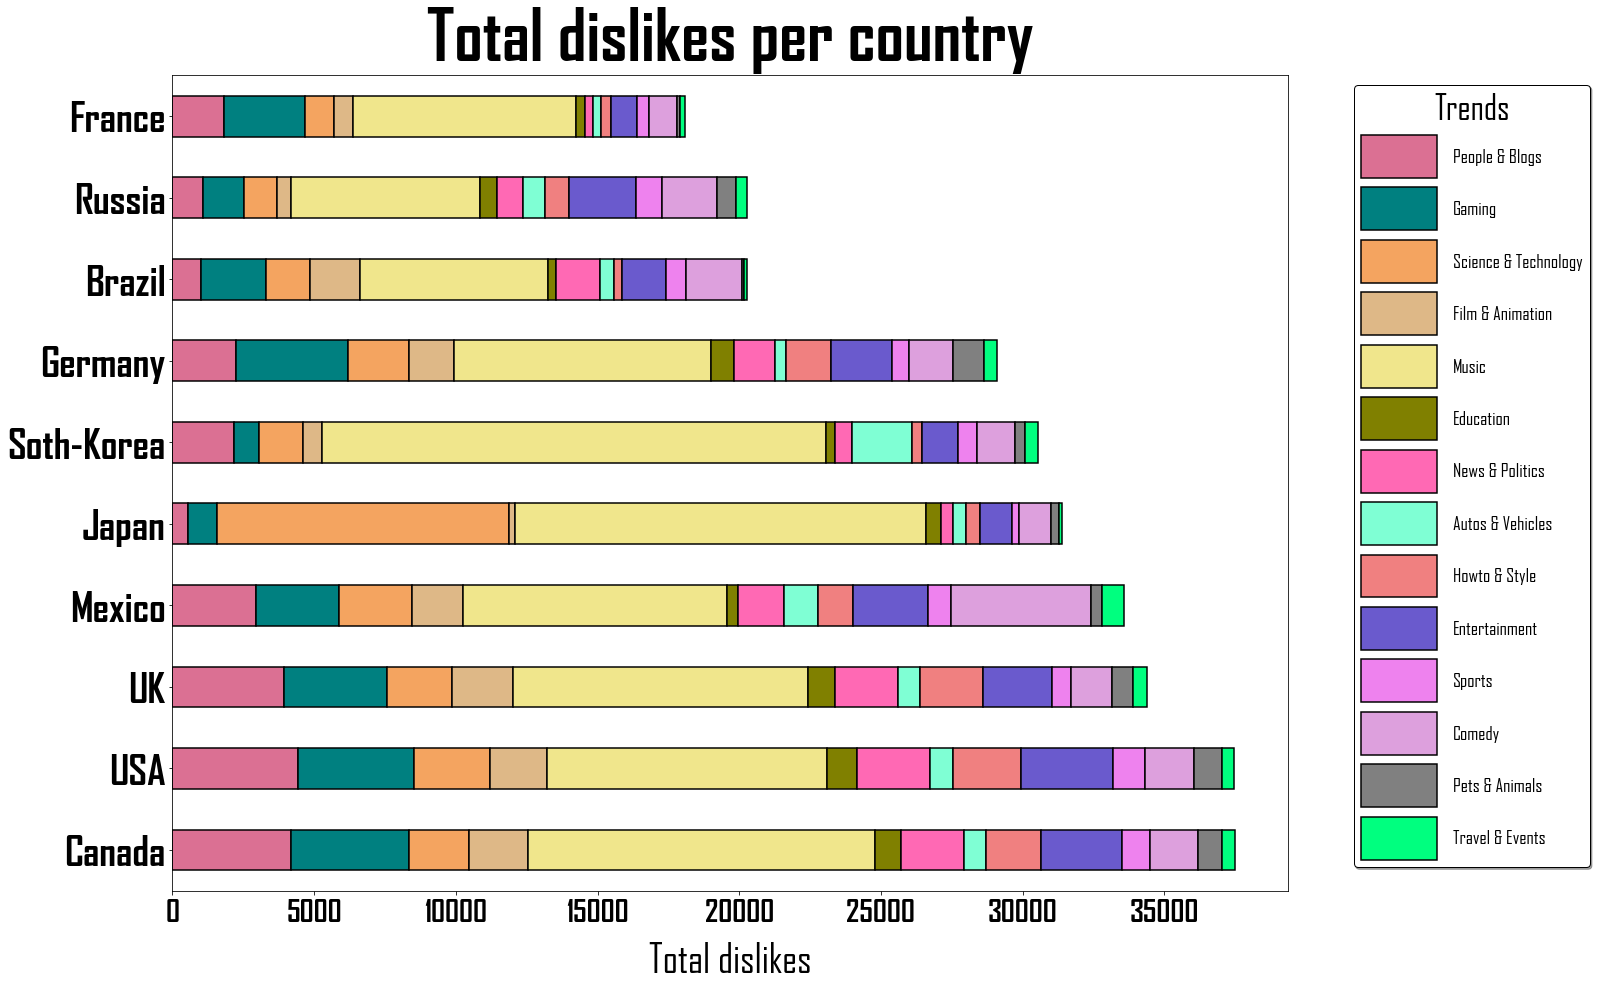

In [18]:
'''
------------------------------Comparing country results - DISLIKES ----------------------------------
'''
fontP = FontProperties()
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams['legend.handlelength'] = 4
plt.rcParams['legend.handleheight'] = 3.1


colors = ["palevioletred","teal","sandybrown","burlywood","khaki","olive",
          "hotpink","aquamarine","lightcoral","slateblue","violet","plum","grey","springgreen"]


#colors = ["lightgreen","mediumspringgreen","turquoise","darkcyan","deepskyblue",
#          "dodgerblue","cornsilk","darkkhaki","olive","peachpuff","lightcoral",
#          "lightsalmon","indianred","darkred"]


# This is the dataframe


countries_dislike_ordered.T.plot(kind="barh",stacked=True,color=colors,linewidth=1.5,edgecolor="k")


# Adjusting xticks and yticks
positions = (0,1,2,3,4,5,6,7,8,9)
labels_dislikes=["Canada","USA","UK","Mexico","Japan","Soth-Korea","Germany",
                "Brazil","Russia","France"]

plt.yticks(positions,labels=labels_dislikes,size=41,fontweight="bold")
plt.xticks(size=30,fontweight="bold")
plt.title("Total dislikes per country",size=70,fontweight="bold",pad=15)
plt.xlabel("Total dislikes",size=40,labelpad=15)
 

# Adding legend
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left',prop={"size":19},
           shadow=True,facecolor="white",edgecolor="k",title="Trends",title_fontsize=35)

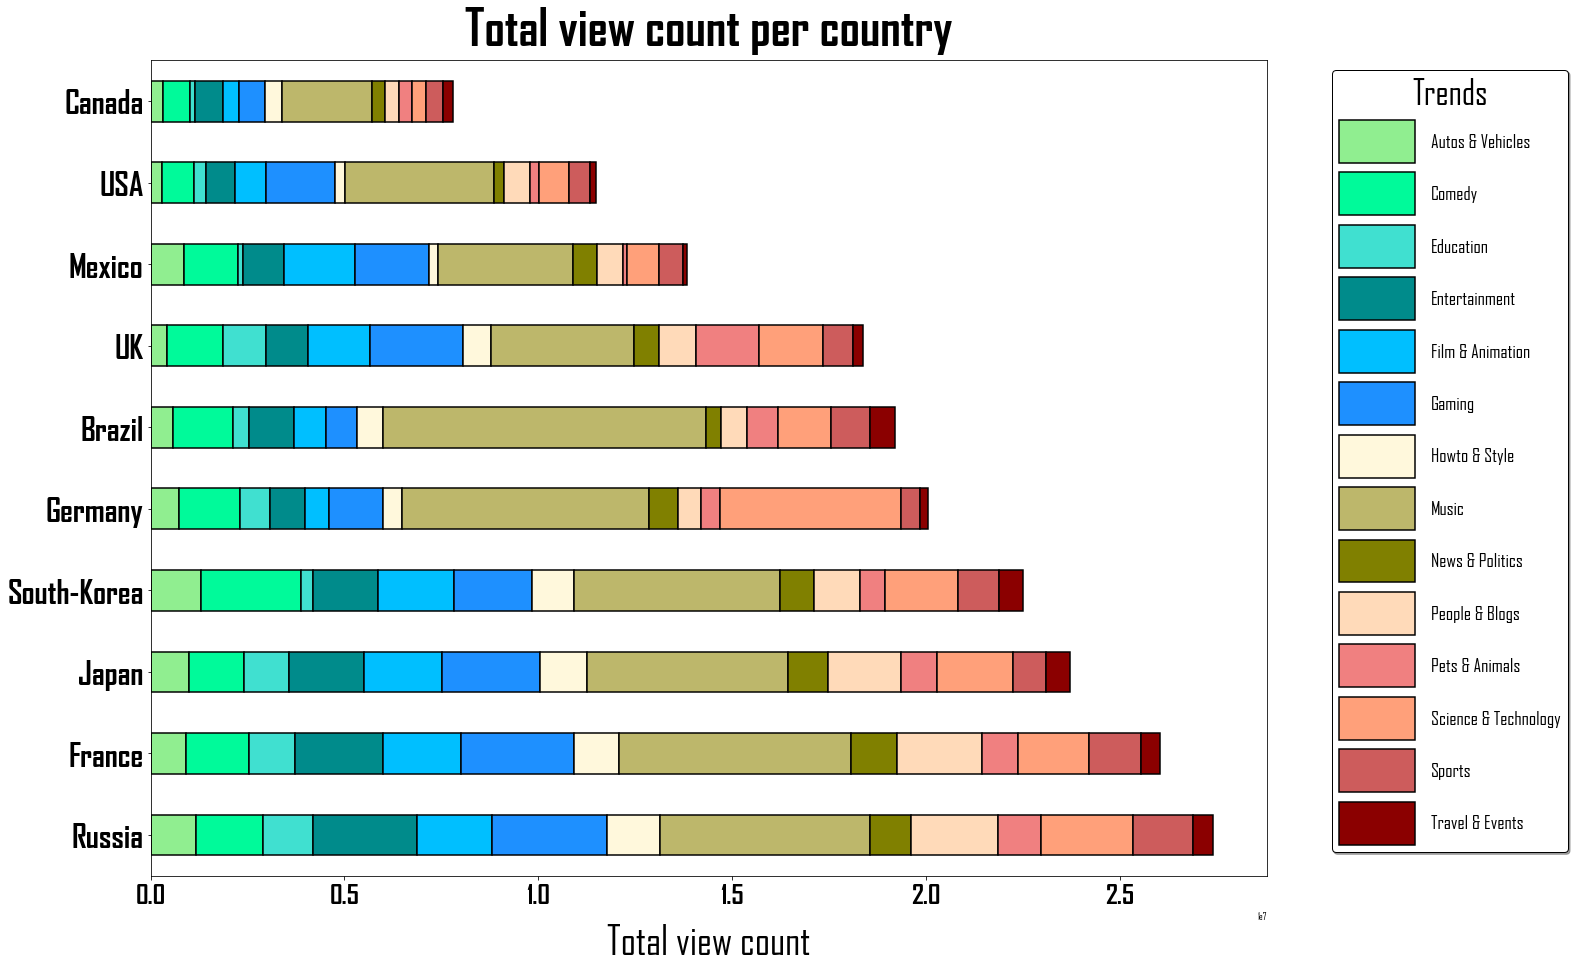

In [19]:
'''
------------------------------Comparing country results - VIEW_COUNT --------------------------------
'''
# Setting Parameters
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams['legend.handlelength'] = 4
plt.rcParams['legend.handleheight'] = 3.1
fontP = FontProperties()

#colors = ["palevioletred","teal","sandybrown","burlywood","khaki","olive",
#          "hotpink","aquamarine","lightcoral","slateblue","violet","plum","grey","springgreen"]


colors = ["lightgreen","mediumspringgreen","turquoise","darkcyan","deepskyblue",
          "dodgerblue","cornsilk","darkkhaki","olive","peachpuff","lightcoral",
          "lightsalmon","indianred","darkred"]

# This is the dataframe
countries_view_count_ordered.T.plot(kind="barh",stacked=True,
                                    color=colors,linewidth=1.5,edgecolor="k")

# Adjusting xticks and yticks
positions = (0,1,2,3,4,5,6,7,8,9)
labels_likes=["Russia","France","Japan","South-Korea","Germany","Brazil","UK",
                "Mexico","USA","Canada"]

plt.yticks(positions,labels=labels_likes,size=32,fontweight="bold")
plt.xticks(size=27,fontweight="bold")
plt.title("Total view count per country",size=50,fontweight="bold",pad=15)
plt.xlabel("Total view count",size=40,labelpad=15)
 
# Adding legend
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left',prop={"size":19},
           shadow=True,facecolor="white",edgecolor="k",title="Trends",title_fontsize=35)

In [20]:
'''
Checking top trends for each country - can be used to reduce trend # in graphs
'''
top_trends_dislikes=[]
for clmn in countries_dislike_ordered.columns:
    top_trends_dislikes.append(countries_dislike_ordered[clmn].nlargest(3).index)
# Top trends for dislikes: Music",Gaming,People & Blogs,Comedy,Science & Technology

top_trends_likes=[]
for clmn in countries_like_ordered.columns:
    top_trends_likes.append(countries_like_ordered[clmn].nlargest(3).index)
    
top_trends_likes
# Top trends for likes: Music, Comedy, Entertainment, Gaming, Science & Tech

[Index(['Music', 'Comedy', 'Entertainment'], dtype='object', name='trend'),
 Index(['Music', 'Entertainment', 'Comedy'], dtype='object', name='trend'),
 Index(['Music', 'Comedy', 'Gaming'], dtype='object', name='trend'),
 Index(['Music', 'Comedy', 'Entertainment'], dtype='object', name='trend'),
 Index(['Music', 'Comedy', 'Gaming'], dtype='object', name='trend'),
 Index(['Music', 'Comedy', 'Gaming'], dtype='object', name='trend'),
 Index(['Music', 'Comedy', 'Entertainment'], dtype='object', name='trend'),
 Index(['Music', 'Science & Technology', 'Comedy'], dtype='object', name='trend'),
 Index(['Music', 'Comedy', 'Gaming'], dtype='object', name='trend'),
 Index(['Music', 'Entertainment', 'Comedy'], dtype='object', name='trend')]

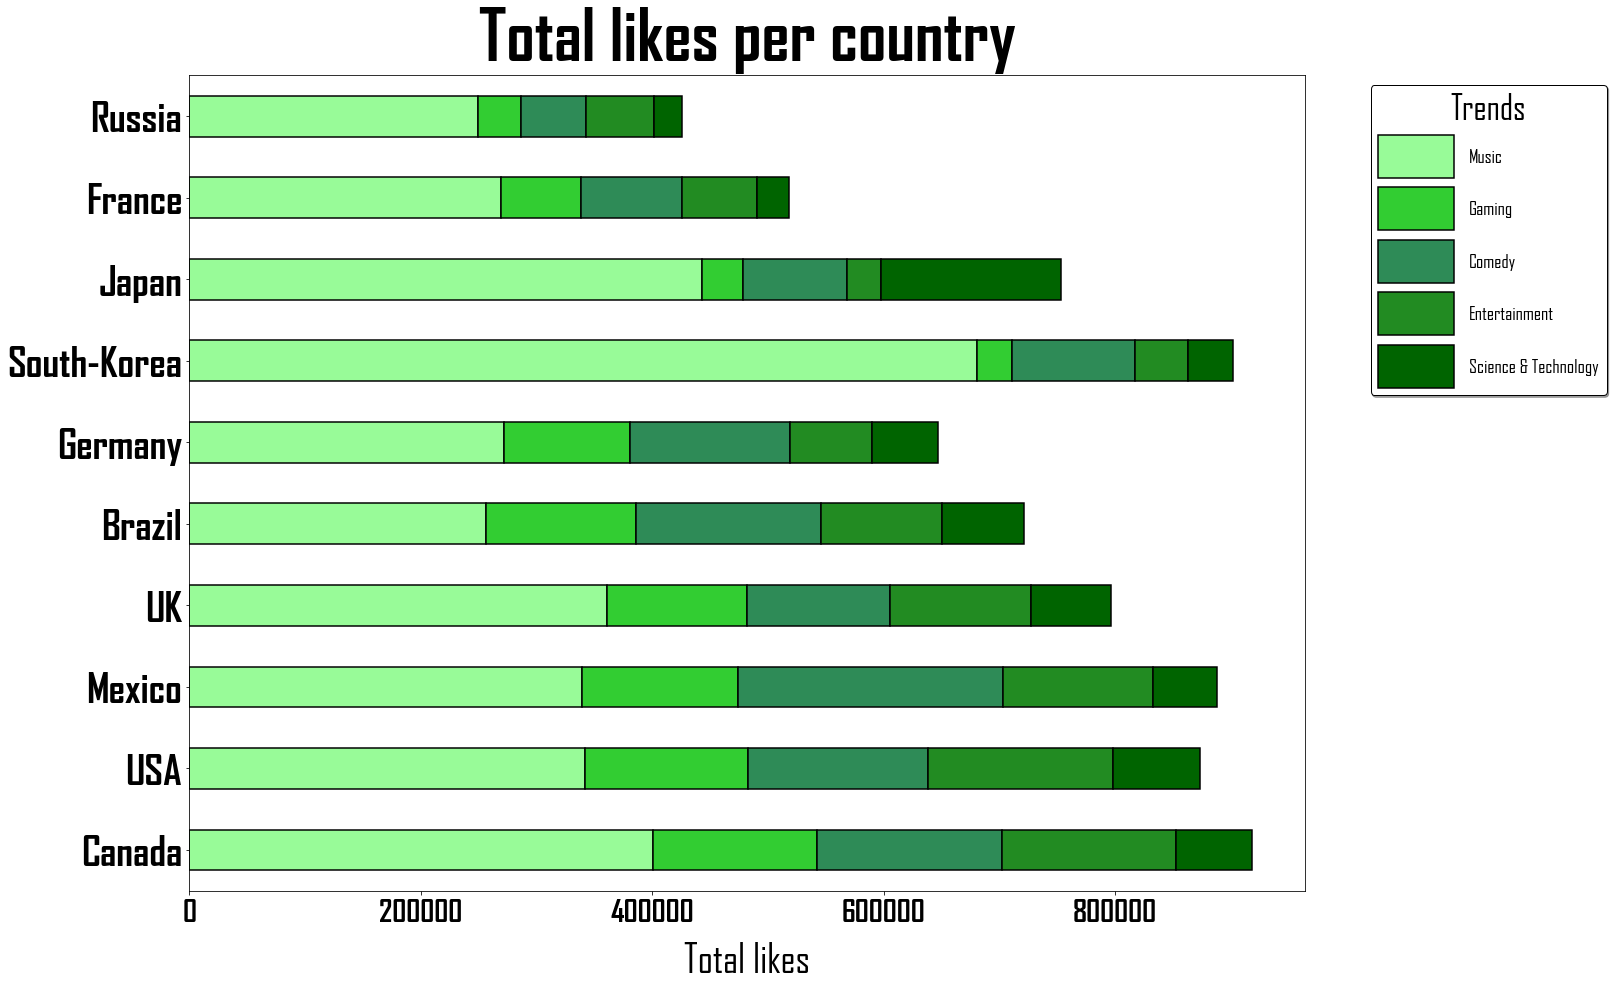

In [48]:
'''
                                SAME GRAPH WITH LESS TRENDS
                                  MORE EASIER TO READ IMO
                                
------------------------------Comparing country results - LIKES ----------------------------------
'''
# Setting Parameters
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams['legend.handlelength'] = 4
plt.rcParams['legend.handleheight'] = 3.1
fontP = FontProperties()


colors = ["palegreen","limegreen","seagreen","forestgreen","darkgreen"]

# This is the dataframe
countries_like_ordered.T[["Music","Gaming","Comedy",
                             "Entertainment","Science & Technology"]].plot(
    kind="barh",stacked=True,color=colors,linewidth=1.5,edgecolor="k")

# Adjusting xticks and yticks
positions = (0,1,2,3,4,5,6,7,8,9)
labels_likes=["Russia","France","Japan","South-Korea","Germany","Brazil","UK",
                "Mexico","USA","Canada"]

plt.yticks(positions,labels=labels_likes[::-1],size=41,fontweight="bold")
plt.xticks(size=30,fontweight="bold")
plt.title("Total likes per country",size=70,fontweight="bold",pad=15)
plt.xlabel("Total likes",size=40,labelpad=15)
 
# Adding legend
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left',prop={"size":19},
           shadow=True,facecolor="white",edgecolor="k",title="Trends",title_fontsize=35)

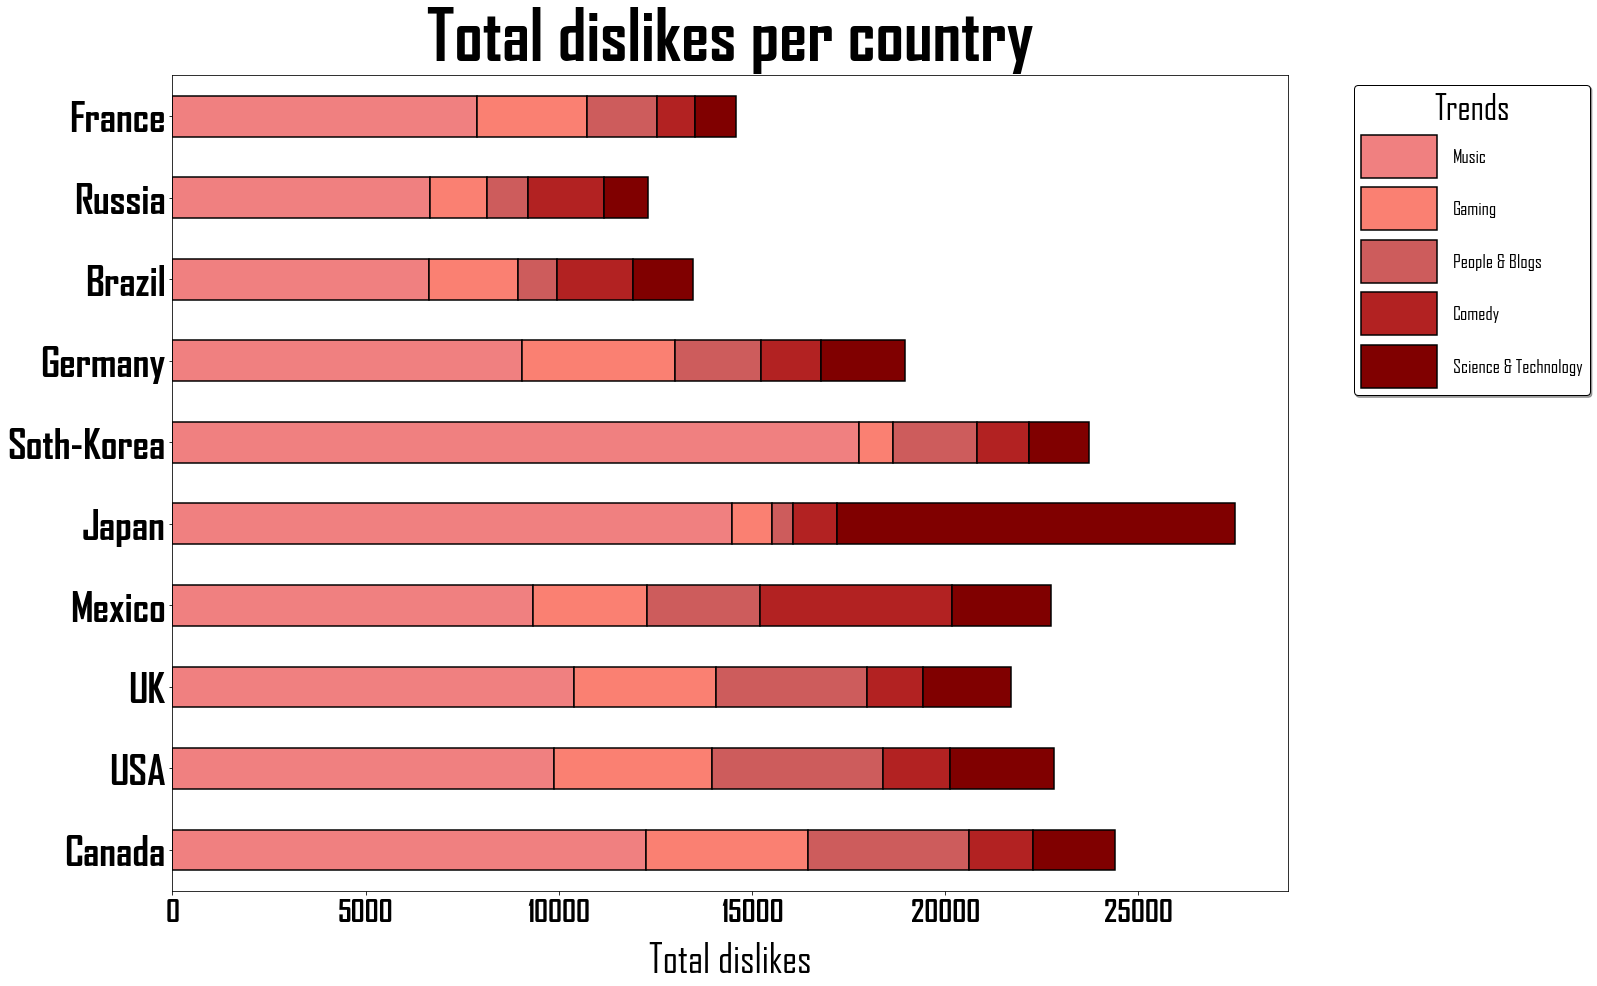

In [35]:
'''
                                SAME GRAPH WITH LESS TRENDS
                                  MORE EASIER TO READ IMO
                                  
------------------------------Comparing country results - DISLIKES ----------------------------------
'''

fontP = FontProperties()
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams['legend.handlelength'] = 4
plt.rcParams['legend.handleheight'] = 3.1

colors = ["lightcoral","salmon","indianred","firebrick","maroon"]


# This is the dataframe
countries_dislike_ordered.T[["Music","Gaming","People & Blogs",
                             "Comedy","Science & Technology"]].plot(
    kind="barh",stacked=True,color=colors,linewidth=1.5,edgecolor="k")



# Adjusting xticks and yticks
positions = (0,1,2,3,4,5,6,7,8,9)
labels_dislikes=["Canada","USA","UK","Mexico","Japan","Soth-Korea","Germany",
                "Brazil","Russia","France"]

plt.yticks(positions,labels=labels_dislikes,size=41,fontweight="bold")
plt.xticks(size=30,fontweight="bold")
plt.title("Total dislikes per country",size=70,fontweight="bold",pad=15)
plt.xlabel("Total dislikes",size=40,labelpad=15)
 

# Adding legend
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left',prop={"size":19},
           shadow=True,facecolor="white",edgecolor="k",title="Trends",title_fontsize=35)

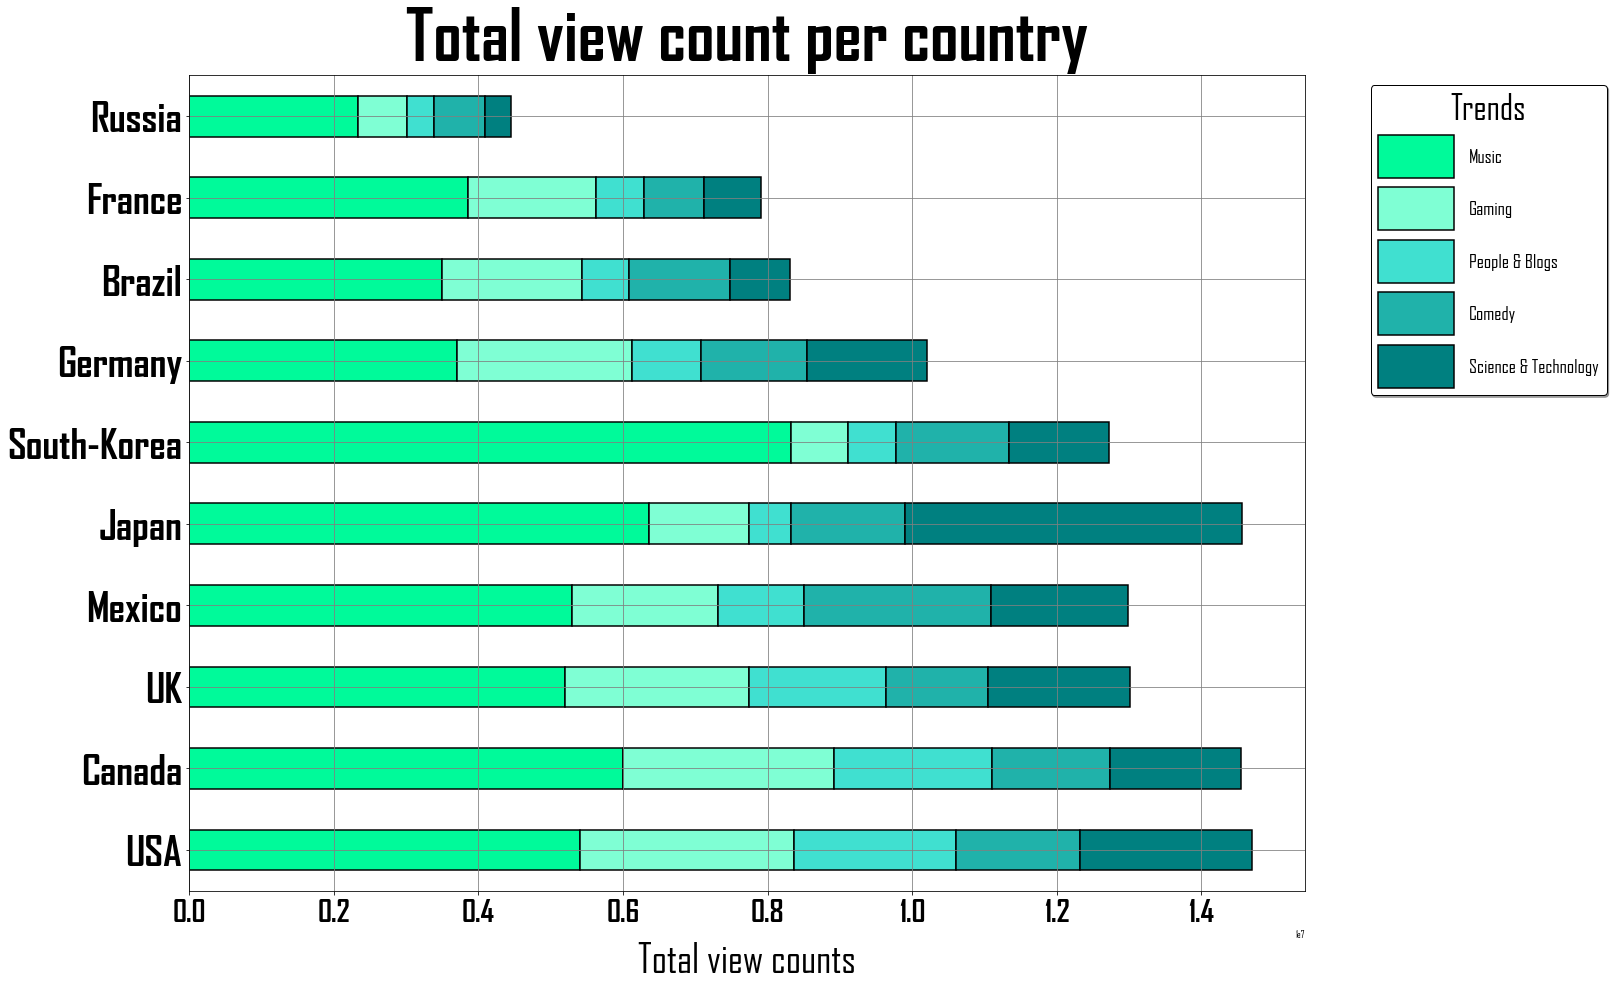

In [52]:
'''
                                SAME GRAPH WITH LESS TRENDS
                                  MORE EASIER TO READ IMO
                                  
------------------------------Comparing country results - VIEW-COUNTS ------------------------------
'''

fontP = FontProperties()
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams['legend.handlelength'] = 4
plt.rcParams['legend.handleheight'] = 3.1

colors = ["mediumspringgreen","aquamarine","turquoise","lightseagreen","teal"]

# This is the dataframe
countries_view_count_ordered.T[["Music","Gaming","People & Blogs",
                             "Comedy","Science & Technology"]].plot(
    kind="barh",stacked=True,color=colors,linewidth=1.5,edgecolor="k")



# Adjusting xticks and yticks
positions = (0,1,2,3,4,5,6,7,8,9)
labels_view_counts=["Russia","France","Brazil","Germany","South-Korea",
                    "Japan","Mexico","UK","Canada","USA"]

plt.yticks(positions,labels=labels_view_counts[::-1],size=41,fontweight="bold")
plt.xticks(size=30,fontweight="bold")
plt.title("Total view count per country",size=70,fontweight="bold",pad=15)
plt.xlabel("Total view counts",size=40,labelpad=15)
 

# Adding legend
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left',prop={"size":19},
           shadow=True,facecolor="white",edgecolor="k",title="Trends",title_fontsize=35)

plt.grid(color="gray")

## Statistical Analysis

### Confidence Intervals

In [64]:
"""
Finding confidence intervals to determine the mean of our data. 
"""

# Computing variables
us_likes = data_us_unique['likes']
us_likes_stdev = us_likes.std()
degree_freedom = len(us_likes) - 1

t = stats.t.interval(0.95, degree_freedom)[1]

# Terms
mean = us_likes.mean()
std_sample = np.sqrt(abs(np.sum((us_likes - mean)**2) / (1-len(us_likes))))
marg_of_error = std_sample / np.sqrt(len(us_likes))
con_int = [mean - (t * marg_of_error) , mean + (t * marg_of_error)]

print('With 95% confidence, the true mean lies in the inverval:', con_int)

#add the middle point

With 95% confidence, the true mean lies in the inverval: [134982.77747488924, 178463.03051220236]


### Hypothesis 


#### Hypothesis 1

We decided to test hypothesis related to engagement between countries

Hypothesis 1: View counts are largely similar for the US and UK.

    H0: mu UK == mu US

    H1: mu UK != mu US

In [65]:
"""
First we took a look at the numbers to understand the data set a little better
"""

'\nFirst we took a look at the numbers to understand the data set a little better\n'

In [66]:
print("UK view_count mean is: ",data_gb_unique['view_count'].mean())
print("UK view_count median is: ",data_gb_unique['view_count'].median())
print("UK view_count standard deviation is: ",data_gb_unique['view_count'].std(),"\n")
print("USA view_count mean is: ",data_us_unique['view_count'].mean())
print("USA view_count median is: ",data_us_unique['view_count'].median())
print("USA view_count standard deviation is: ",data_us_unique['view_count'].std())

UK view_count mean is:  2128238.6995253745
UK view_count median is:  687993.0
UK view_count standard deviation is:  7214438.945745977 

USA view_count mean is:  2799942.168212989
USA view_count median is:  1076658.0
USA view_count standard deviation is:  8305210.195639507


In [ ]:
"""
We noticed a big difference in the mean and median and suspected this was due to outliers, so we
plotted these on a scatter plot.
"""

<AxesSubplot:ylabel='view_count'>

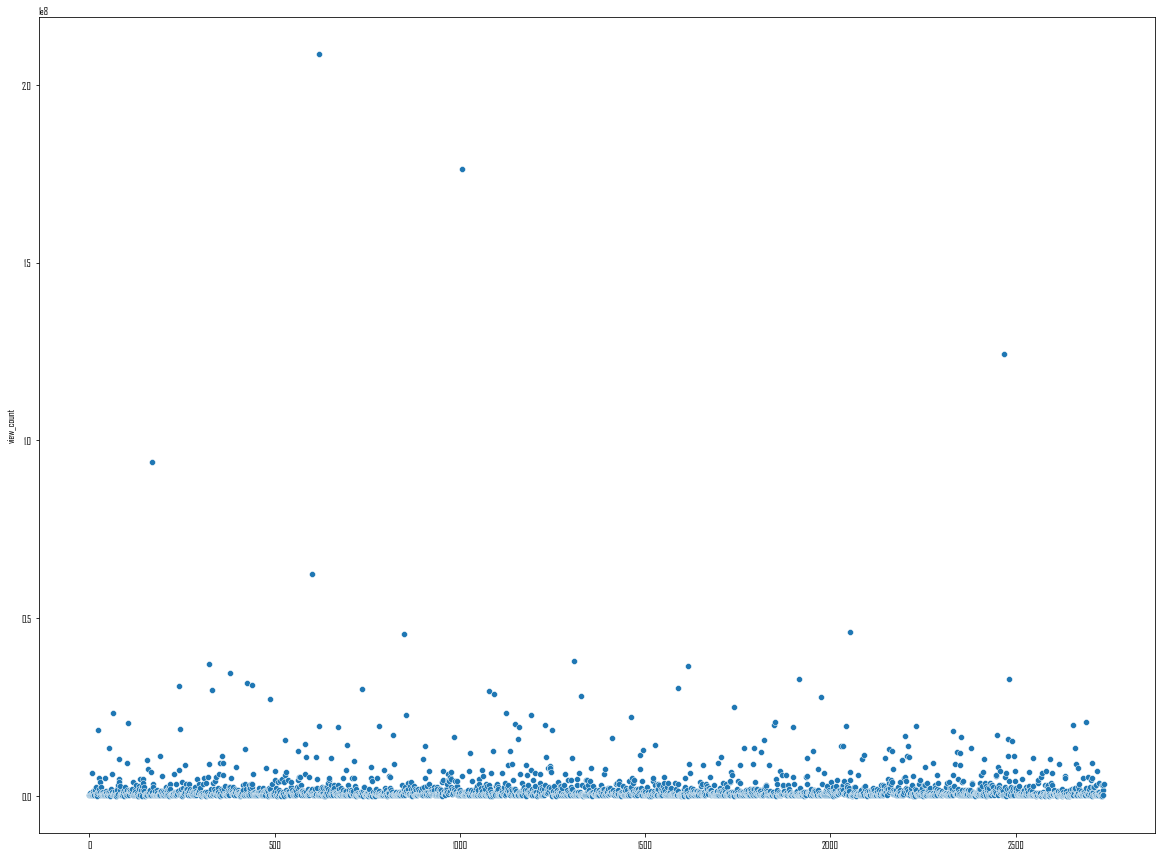

In [75]:
sns.scatterplot(data = data_gb_unique.reset_index(), 
                x = data_gb_unique.reset_index().index, y = 'view_count')

<AxesSubplot:ylabel='view_count'>

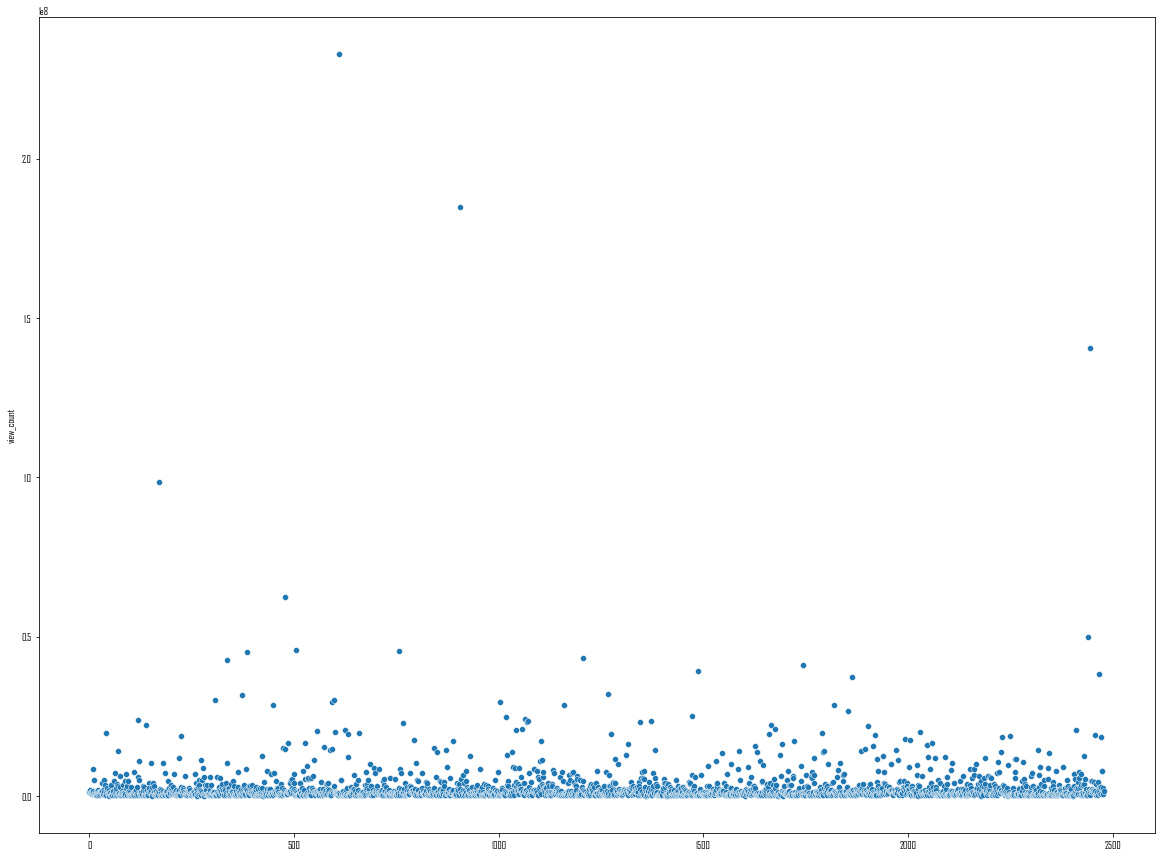

In [76]:
sns.scatterplot(data = data_us_unique.reset_index(), 
                x = data_us_unique.reset_index().index, y = 'view_count')

In [77]:
"""
We removed the top 5 values for both samples as we beleived that these were skewing the data. 
"""

'\nWe removed the top 5 values for both samples as we beleived that these were skewing the data. \n'

In [78]:
# Updating UK database by removing outliers
data_gb_updated = data_gb_unique['view_count'].sort_values(ascending = False).reset_index()
data_gb_updated.head(10)

data_gb_updated = data_gb_updated.drop(index = [0, 1, 2, 3, 4])
data_gb_updated.head(3)

,index,view_count
5,9392,45950142
6,3994,45596902
7,6194,37819586


In [80]:
# Updating US database by removing outliers
data_us_updated = data_us_unique['view_count'].sort_values(ascending = False).reset_index()
data_us_updated = data_us_updated.drop(index = [0, 1, 2, 3, 4])
data_us_updated.head(3)

# Dropping columns for US database
data_us_updated = data_us_unique['view_count'].sort_values(ascending = False).reset_index()
data_us_updated.head(10)

,index,view_count
0,3358,232649205
1,4980,184778248
2,11764,140685439
3,985,98442414
4,2762,62496726
5,11761,49814886
6,2787,45893190
7,3992,45596902
8,2361,45086708
9,6597,43394819


In [86]:
"""
Next we tested our hypotheses using a t test. 
"""
t, p =ttest_ind(data_us_updated['view_count'], data_gb_updated['view_count'], equal_var=False)
print("t :",t)
print("p :",p)

t : 4.97933198618862
p : 6.692232112718823e-07


A p value of zero means null hypothesis can be rejected and therefore we can assume mean is greater than 200k for likes. However, we recognise that a p value of zero is almost impossible in the real world and this hypothesis doesn't really tell us anything meaningful. 

# APPENDIX

Sports engagement in the US is similar to the UK


H0: avg likes US Sports != avg likes UK

H1: avg likes US Sports == avg likes UK

In [ ]:
"""
We spent some time cleaning the data and removing outliers as before
"""

In [ ]:
data_us_sport = data_us_unique[['trend', 'view_count']]
data_us_sport = data_us_sport[data_us_sport['trend']== 'Sports']
data_us_sport = data_us_sport.sort_values('view_count', ascending = False)
data_us_sport.head(10)


In [ ]:
sns.scatterplot(data = data_us_sport)

In [ ]:
data_us_sport_updated = data_us_sport.reset_index()
data_us_sport_updated = data_us_sport_updated.drop(index = [0, 1, 2, 3])
data_us_sport_updated.head(10)

In [ ]:
data_gb_sport = data_gb_unique[['trend', 'view_count']]
data_gb_sport = data_gb_sport[data_gb_sport['trend']== 'Sports']
data_gb_sport = data_gb_sport.sort_values('view_count', ascending = False)
data_gb_sport.head(10)



In [ ]:
sns.scatterplot(data = data_gb_sport)

In [ ]:
data_gb_sport_updated = data_gb_sport.reset_index()
data_gb_sport_updated = data_gb_sport_updated.drop(index = [0, 1, 2])
data_us_sport_updated.head(10)

In [ ]:
ttest_ind(data_us_sport_updated['view_count'], data_gb_sport_updated['view_count'], equal_var=False)

P value is much smaller than the critical alpha value so we can reject the null hypothesis
Assume therefore that sports engagement is statisticall similar in the UK and US.

In [ ]:
data_us_sport_updated['view_count'].mean()

In [ ]:
data_gb_sport_updated['view_count'].mean()

In [ ]:
'''
We can also check each trend one by one 
'''

fontP = FontProperties()
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams['legend.handlelength'] = 4
plt.rcParams['legend.handleheight'] = 3.1


colors = ["palevioletred","teal","sandybrown","burlywood","khaki"]


#colors = ["lightgreen","mediumspringgreen","turquoise","darkcyan","deepskyblue",
#          "dodgerblue","cornsilk","darkkhaki","olive","peachpuff","lightcoral",
#          "lightsalmon","indianred","darkred"]


# This is the dataframe
countries_view_count_ordered.T[["Sports"]].plot(
    kind="barh",stacked=True,color=colors,linewidth=1.5,edgecolor="k")



# Adjusting xticks and yticks
positions = (0,1,2,3,4,5,6,7,8,9)
labels_view_counts=["Russia","France","Brazil","Germany","South-Korea",
                    "Japan","Mexico","UK","Canada","USA"]

plt.yticks(positions,labels=labels_view_counts[::-1],size=41,fontweight="bold")
plt.xticks(size=30,fontweight="bold")
plt.title("Total view count per country",size=70,fontweight="bold",pad=15)
plt.xlabel("Total view counts",size=40,labelpad=15)
 

# Adding legend
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left',prop={"size":19},
           shadow=True,facecolor="white",edgecolor="k",title="Trends",title_fontsize=35)

plt.grid(color="gray")

### Hypothesis Testing

In [82]:
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_1samp
from sklearn.metrics import auc

#### Hypothesis 1

In Germany, quarter of total views on trending videos is for Sports category.

In [ ]:
'''
H0 => p = 0.25
H1 => p != 0.25
'''

In [ ]:
data_de_unique_sports  = data_de_unique[data_de_unique["trend"]=="Sport"]

In [ ]:
confidence_level = 0.95
alpha = 1- confidence_level
sample_proportion = (data_de_unique_sports["view_count"].sum()/
                     data_de_unique["view_count"].sum())#*100
mu_proportion = 0.25
sample_size = len(data_de_unique)

z = (sample_proportion-mu_proportion) / np.sqrt((0.25*0.75)/sample_size)
print("test statitics: ",z)


# Two-sided hypothesis testing
normal = norm(loc = 0, scale = 1) 

alpha_left = 0.025
alpha_left = normal.ppf(alpha_left)
print("Alpha Left Tail: ",alpha_left)

alpha_right = 1 - 0.025
alpha_right = normal.ppf(alpha_right)
print('Alpha Right Tail: ', alpha_right)


#drawing the graph

plt.rcParams["figure.figsize"]=(12,6)
fig, ax = plt.subplots(1,1)
x = np.linspace(-3,3,1000)
y = normal.pdf(x)
ax.plot(x,y)
plt.plot([alpha_right, alpha_right], [0, 0.4], 'k--', lw=4, color='green',label="critical_values")
plt.legend(loc="best",prop={"size":14})
plt.plot([alpha_left, alpha_left], [0, 0.4], 'k--', lw=4, color='green')
plt.fill_between(x,y, where = x >= alpha_right, color='r')
plt.fill_between(x,y, where = x <=alpha_left, color='r')

'''
Since test statistics are waay smaller then left critical value, it is in the rejection area, 
therefore we do reject the null hypothesis and accept hypothesis 1 which implies that
in germany quarter of total views on trending videos are not belong to sports category.
'''
if (z < alpha_right) & (z > alpha_left):
    print("Support null hypothesis")
else:
    print("Null hytpothesis is rejected")

In [ ]:
'''
Creating Pivot Table Function (categorized_pivot_table)

- Will be applied for each country
- Will be used for visaulization

'''
data_unique_countries = [data_gb_unique,data_fr_unique,data_us_unique,data_ru_unique,
                         data_de_unique,data_ca_unique,data_kr_unique,data_jp_unique
                         ,data_br_unique,data_mx_unique]

def categorized_pivot_table(df):
    
    categorized_pivot_table = pd.pivot_table(df,values=(
        "view_count","likes","dislikes","comment_count",),index="trend")
    return categorized_pivot_table

In [ ]:
'''
Creating Subplots Function (plot_drawer)
- All countries will be drawn once applied
'''

plot_columns = ["view_count","likes","dislikes","comment_count"]
plot_colors = ["lightblue","green","red","darkorange"]
plot_titles = ["View counts per Trend","Likes per Trend",
               "Dislikes per Trend","Comment counts per Trend"]
plot_titles_countries = ["UK","France","USA","Russia","Germany","Canada",
                         "SouthKorea","Japan","Brazil","Mexico"]



def plot_drawer(df_pivot,plot_cols,plot_titles):
    plt.rc('font', weight='bold')
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    plt.rcParams["figure.figsize"] = (14,40)
    
    fig1, ax = plt.subplots(4,1)
    

    for subplot_index in range(0,4):
        
        df_pivot[[plot_columns[subplot_index]]].sort_values(
        by=plot_columns[subplot_index],ascending=False).plot.barh(
        ax=ax[subplot_index],stacked=True,edgecolor="k",lw=1,color=plot_colors[subplot_index])
        
        
        ax[subplot_index].set_title(plot_titles[subplot_index],size=28,
                                    fontweight="bold",pad=10,color="k")
    
    
        legend_fix = mpatches.Patch(color=plot_colors[subplot_index], 
                                      label=plot_columns[subplot_index])
        ax[subplot_index].legend(handles=[legend_fix],edgecolor="k",prop={"size":22})
        
        ax[subplot_index].grid(True,color="k",ls=":")
        
    
        #only for this one
        ax[0].get_xaxis().get_major_formatter().set_scientific(False)

In [ ]:
'''
Applying plot function & pivot_table function to all databases;
'''
plot_titles_countries = {1:"UK",2:"France",3:"USA",4:"Russia",5:"Germany",6:"Canada",
                         7:"SouthKorea",8:"Japan",9:"Brazil",10:"Mexico"}


# Creating fake plot for title
fig2, ax = plt.subplots(1,1,figsize=(20,1))
ax.plot([1,1],[1,1],label="UK")
ax.legend(loc="center",edgecolor="k",prop={"size":55})
plt.axis('off')


c = 1
for unique_country in data_unique_countries:
    plot_drawer(categorized_pivot_table(unique_country),plot_colors,plot_titles)
    
    # Creating fake plots as title
    if c < 10:
        fig2, ax = plt.subplots(1,1,figsize=(20,1))
        ax.plot([1,1],[1,1],label=plot_titles_countries[c+1])
        ax.legend(loc="center",edgecolor="k",prop={"size":55})
        plt.axis('off')
        c += 1